In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *
# %matplotlib widget
# import ipywidgets as widgets

In [2]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\omni_9dof_feb_28_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  -_sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = _sk_df["e_rl"]

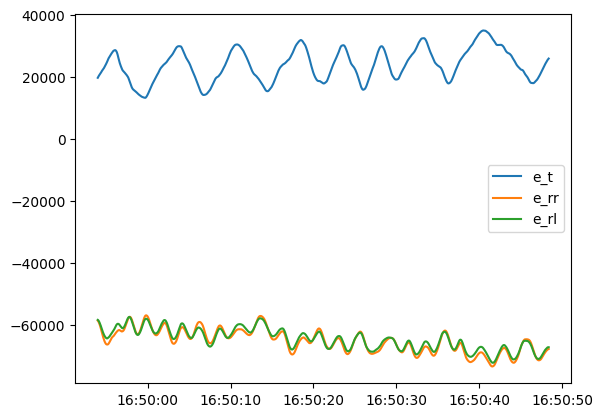

In [4]:
inx = 5000
s_inx = 45000

plt.plot(_sk_df["time"][s_inx:s_inx + inx], _sk_df["e_t"][s_inx:s_inx+inx], label="e_t")
plt.plot(_sk_df["time"][s_inx:s_inx + inx], _sk_df["e_rr"][s_inx:s_inx+inx], label="e_rr")
plt.plot(_sk_df["time"][s_inx:s_inx + inx], _sk_df["e_rl"][s_inx:s_inx+inx], label="e_rl")

# plt.plot(_sk_df["time"], _sk_df["e_t"], label="e_t")
# plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
# plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [5]:
y = (19.5/2)/100 # meters
x = 7.5/100 # meters
radius = 5.5/200 # meters

df = _sk_df.copy()
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.09, del_t=0.01)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)


In [6]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(1)
_om = get_marker_name(3)

In [7]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

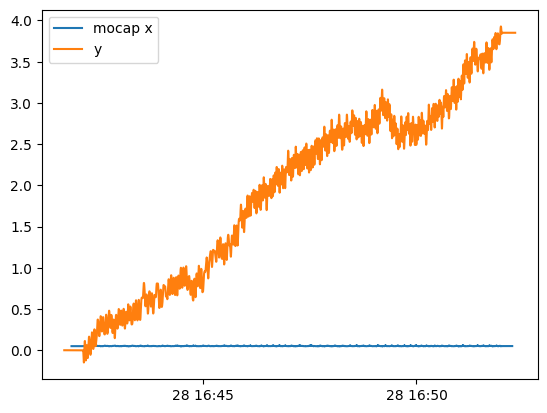

In [8]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["y"]], label="mocap x")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

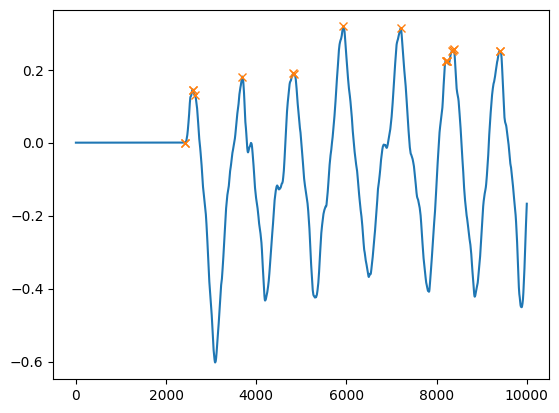

In [9]:
peaks, _ = find_peaks(df["x_val"][:10000], height=0)
plt.plot(df["x_val"][:10000])
plt.plot(peaks, df["x_val"][:10000][peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

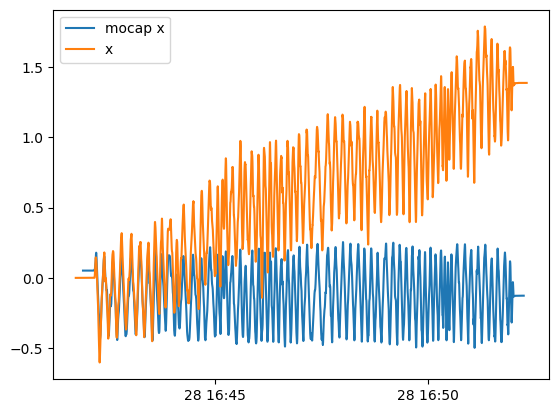

In [10]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["x"]], label="mocap x")
plt.plot(df.time, df["x_val"], label="x")

# plt.plot(df["w"], label="theta")
plt.legend()

In [11]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [12]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [13]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 61959/61959 [00:15<00:00, 3922.10it/s]


In [14]:
_upper_limit = max(-_mc_df.x)
_lower_limit = min(-_mc_df.x)
print(_upper_limit, _lower_limit)

0.2108922483888862 -0.5548096718654233


In [15]:
_vx = []
_vx_pos = 0
for idx, val in enumerate(df.vx):
    if idx == 0:
        _vx.append(0)
    else:
        _vx_pos += 0.5*(val + df.vx.iloc[idx-1])*0.01
        _vx.append(_vx_pos)

        if _vx[idx] > _upper_limit:
            if 0.5*(val + df.vx.iloc[idx-1])*0.01 < 0:
                _vx_pos += 0.5*(val + df.vx.iloc[idx-1])*0.01
                _vx[idx] = _vx_pos
            else:
                _vx[idx] = _upper_limit

        if _vx[idx] < _lower_limit:
            
            if 0.5*(val + df.vx.iloc[idx-1])*0.01 > 0:
                _vx_pos += 0.5*(val + df.vx.iloc[idx-1])*0.01
                _vx[idx] = _vx_pos
            else:
                _vx[idx] = _lower_limit

_vx_filtered = []

for i in _vx:
    if i > _upper_limit:
        _vx_filtered.append(_upper_limit)
    elif i < _lower_limit:
        _vx_filtered.append(_lower_limit)
    else:
        _vx_filtered.append(i)

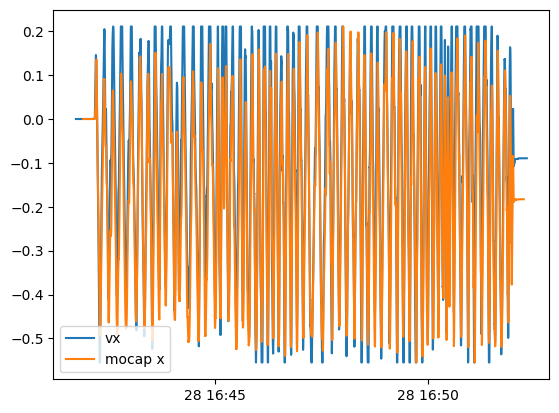

In [16]:
inx = 100000
plt.plot(df.time[:inx], _vx_filtered[:inx], label="vx")
plt.plot(_mc_df.time[:inx], -_mc_df["x"][:inx], label="mocap x")
# plt.plot(df.vx, label="vx")
# plt.plot(df.x_val, label="x")
plt.legend()

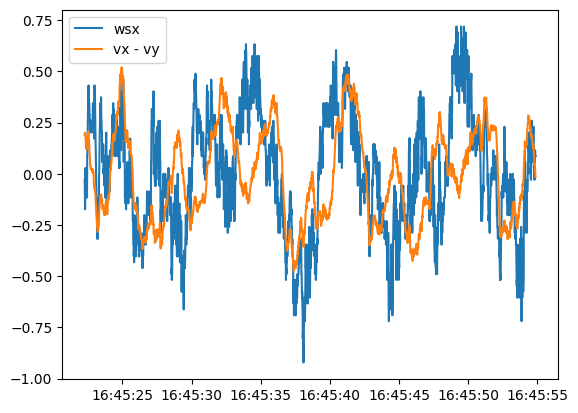

In [17]:
inx = 3000
s_inx = 20000

_temp = df.vx  - df.vy
plt.plot(df["time"][s_inx:s_inx + inx], df.w[s_inx:s_inx + inx], label="wsx")
plt.plot(df["time"][s_inx:s_inx + inx], _temp[s_inx:s_inx + inx], label="vx - vy")
plt.legend()

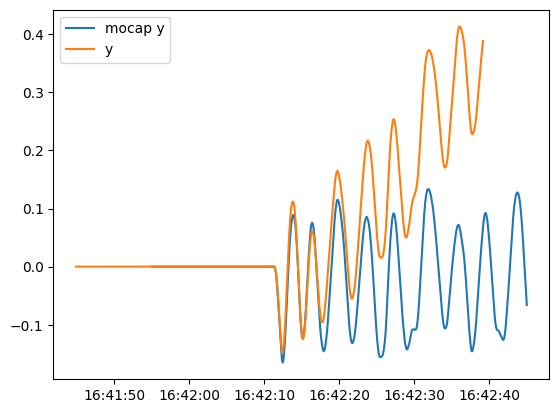

In [18]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time[:5000], _mc_df.y[:5000], label="mocap y")
plt.plot(df.time[:5000], df["y_val"][:5000], label="y")

# plt.plot(df["w"], label="theta")  
plt.legend()

In [19]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 61959/61959 [00:00<00:00, 118553.08it/s]


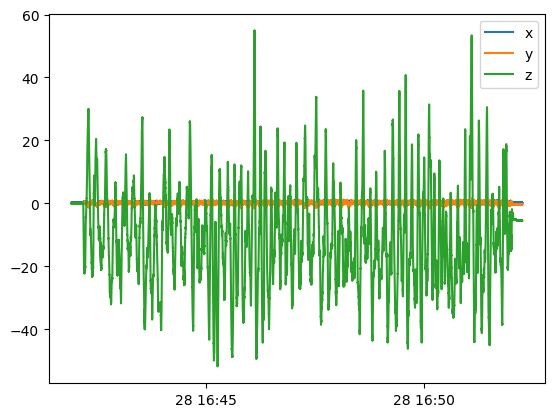

In [20]:
# plt.plot(df.time, np.rad2deg(df["theta"]), label="y")
plt.plot(_m_df["time"], _theta_x, label="x")
plt.plot(_m_df["time"], _theta_y, label="y")
plt.plot(_m_df["time"], _theta_z, label="z")
plt.legend()


In [21]:
_imu_df = calculate_imu_orientation(df)
_vel_df = calculate_imu_velocity(df, filter_size=51, filter_order=1, zero_drift=300)

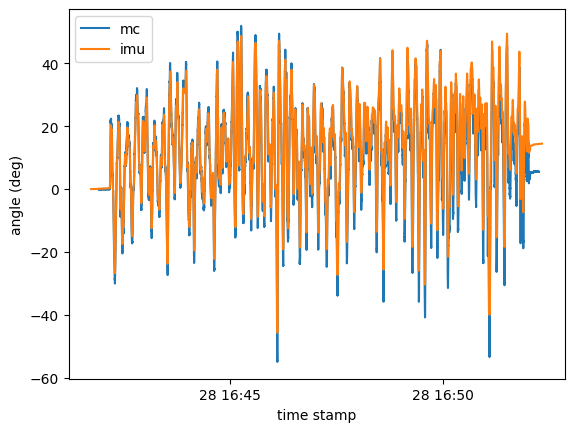

In [22]:
inx = 10000
# plt.plot(df["time"][:inx], np.rad2deg(df["theta"][:inx]/2), label="sk")
plt.plot(_m_df["time"][:], -_theta_z[:], label="mc")
plt.plot(_imu_df["time"][:], -_imu_df["angle_gz"][:], label="imu")
plt.ylabel("angle (deg)")
plt.xlabel("time stamp")
plt.legend()

In [23]:
# _accel_df = calculate_imu_acceleration(df)
_disp_df = calculate_imu_displacement(_vel_df, filter_size=1, filter_order=1, zero_drift=1)

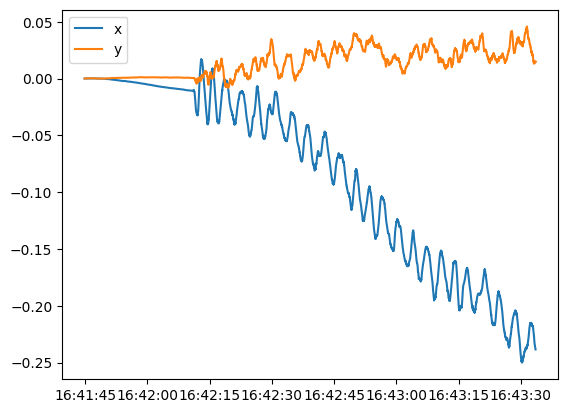

In [24]:
plt.plot(_vel_df["time"][:inx], _vel_df["vel_x"][:inx], label="x")
plt.plot(_vel_df["time"][:inx], _vel_df["vel_y"][:inx], label="y")
# plt.plot(_accel_df["time"][:inx], _accel_df["vel_z"][:inx], label="z")
plt.legend()

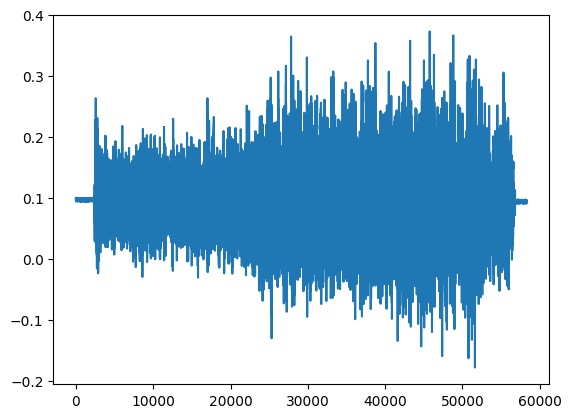

In [25]:
# plt.plot(df.ay - df.ay[:300].mean(), label="ax")
plt.plot(df.ax, label="ax")

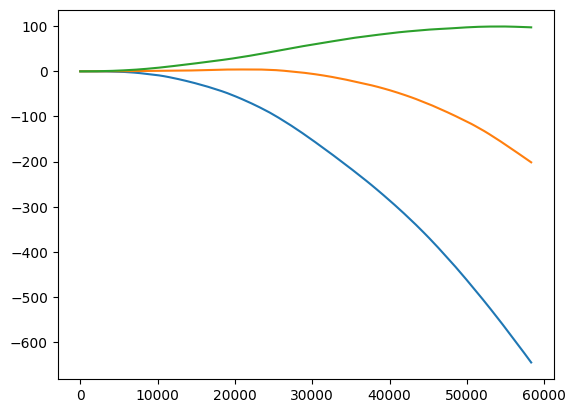

In [26]:
plt.plot(_disp_df.disp_x)
plt.plot(_disp_df.disp_y)
plt.plot(_disp_df.disp_z)